<a href="https://colab.research.google.com/github/Dhingraakshat/Fraud-detection/blob/main/Base_Models/V43(Autoencoder).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install dependencies (quiet)
!pip -q install optuna shap scikit-learn tensorflow matplotlib numpy pandas tqdm

import os, sys, warnings, math, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve,
                             confusion_matrix, classification_report,
                             f1_score, accuracy_score, precision_score, recall_score)

import optuna
import shap

warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', 200)

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Optional: play nice with GPU memory
gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except:
        pass
print("TF:", tf.__version__, "| Num GPUs detected:", len(gpus))

# Detect Colab and mount Drive (if needed)
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

# Your paths (from your prompt)
datapath = '/content/drive/MyDrive/RThesis/' if IN_COLAB else './'
train_path = os.path.join(datapath, "X_train_scaled.csv")
test_path  = os.path.join(datapath, "X_test_scaled.csv")
y_train_path = os.path.join(datapath, "y_train.csv")
y_test_path  = os.path.join(datapath, "y_test.csv")


TF: 2.19.0 | Num GPUs detected: 1
Mounted at /content/drive


In [ ]:
#@title Load dataframes
X_train = pd.read_csv(train_path)
X_test  = pd.read_csv(test_path)

ytr_df = pd.read_csv(y_train_path)
yte_df = pd.read_csv(y_test_path)

# Try to detect the label column
label_col = None
for cand in ['isFraud', 'fraud', 'label', 'target', 'y']:
    if cand in ytr_df.columns:
        label_col = cand
        break
if label_col is None:
    # assume first column
    label_col = ytr_df.columns[0]

y_train = ytr_df[label_col].astype(int).values
y_test  = yte_df[label_col].astype(int).values

# Keep an eye on chronology via TransactionDT if it's present
TX_TIME_COL = 'TransactionDT' if 'TransactionDT' in X_train.columns else None

print("Shapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)
if TX_TIME_COL:
    print("TransactionDT present; verifying sorted order...")
    assert X_train[TX_TIME_COL].is_monotonic_increasing, "X_train NOT sorted by TransactionDT!"
    assert X_test[TX_TIME_COL].is_monotonic_increasing, "X_test NOT sorted by TransactionDT!"
else:
    print("TransactionDT NOT found as a column in X_* (that's fine if already sorted externally).")

# Feature matrix (drop TransactionDT from features if you don't want it to drive anomaly score):
# Here, we KEEP it as a signal since your scaled set likely includes it on purpose.
feature_cols = [c for c in X_train.columns]  # use all columns as provided
X_train_mat = X_train[feature_cols].values.astype(np.float32)
X_test_mat  = X_test[feature_cols].values.astype(np.float32)

print("Using", len(feature_cols), "features.")
classes, counts = np.unique(y_train, return_counts=True)
print("Train class balance:", dict(zip(classes, counts)))


Shapes:
X_train: (472432, 47) X_test: (118108, 47)
y_train: (472432,) y_test: (118108,)
TransactionDT present; verifying sorted order...
Using 47 features.
Train class balance: {np.int64(0): np.int64(455833), np.int64(1): np.int64(16599)}


In [ ]:
feature_cols = [c for c in X_train.columns if c != "dist_ratio"]
X_train_mat = X_train[feature_cols].values.astype(np.float32)
X_test_mat  = X_test[feature_cols].values.astype(np.float32)


In [ ]:
#@title Helpers: build model, reconstruction error, metrics, threshold search

def build_autoencoder(input_dim,
                      hidden_layers,      # list of units for encoder (decoder mirrors)
                      activation='relu',
                      dropout=0.0,
                      l2=0.0,
                      learning_rate=1e-3):
    keras.backend.clear_session()
    reg = regularizers.l2(l2) if l2 and l2 > 0 else None

    inp = keras.Input(shape=(input_dim,), name="inp")
    x = inp

    # Encoder
    for i, units in enumerate(hidden_layers):
        x = layers.Dense(units, activation=None, kernel_regularizer=reg)(x)
        if activation == 'leaky_relu':
            x = layers.LeakyReLU()(x)
        elif activation == 'selu':
            x = layers.Activation('selu')(x)
        elif activation == 'elu':
            x = layers.ELU()(x)
        else:
            x = layers.Activation('relu')(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout)(x)

    # Latent
    latent_dim = max(2, hidden_layers[-1] if hidden_layers else max(2, input_dim // 4))
    z = layers.Dense(latent_dim, activation=None, name="latent")(x)

    # Decoder (mirror)
    x = z
    for i, units in enumerate(reversed(hidden_layers)):
        x = layers.Dense(units, activation=None, kernel_regularizer=reg)(x)
        if activation == 'leaky_relu':
            x = layers.LeakyReLU()(x)
        elif activation == 'selu':
            x = layers.Activation('selu')(x)
        elif activation == 'elu':
            x = layers.ELU()(x)
        else:
            x = layers.Activation('relu')(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout)(x)

    out = layers.Dense(input_dim, activation='linear', name="recon")(x)
    model = keras.Model(inp, out, name="autoencoder")

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse')
    return model

def reconstruction_error(model, X, batch_size=1024):
    X_pred = model.predict(X, batch_size=batch_size, verbose=0)
    err = np.mean(np.square(X - X_pred), axis=1)
    return err

def evaluate_scores(y_true, scores, threshold):
    y_pred = (scores >= threshold).astype(int)   # higher score = more anomalous (fraud)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    metrics = {
        "roc_auc": roc_auc_score(y_true, scores),
        "pr_auc": average_precision_score(y_true, scores),
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "cm": cm
    }
    return metrics, y_pred

def best_threshold_by_f1(y_true, scores, quantiles=None):
    """Search threshold that maximizes F1 on (y_true, scores)."""
    if quantiles is None:
        quantiles = np.linspace(0.80, 0.999, 100)
    cands = np.unique(np.quantile(scores, quantiles))
    best_f1, best_th = -1.0, np.quantile(scores, 0.995)  # safe default
    for th in cands:
        f1 = f1_score(y_true, (scores >= th).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1, best_th = f1, th
    return float(best_th), float(best_f1)

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks); ax.set_yticks(tick_marks)
    ax.set_xticklabels(['Non-Fraud(0)','Fraud(1)']); ax.set_yticklabels(['Non-Fraud(0)','Fraud(1)'])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center")
    ax.set_ylabel('True'); ax.set_xlabel('Predicted')
    fig.tight_layout()
    plt.show()


In [ ]:
#@title TimeSeries 5-fold Optuna tuning on the training set
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)  # preserves chronology
INPUT_DIM = X_train_mat.shape[1]

def make_hidden_layers(trial, input_dim):
    # Geometric progression from input_dim towards a latent, mirrored later
    n_layers = trial.suggest_int("n_layers", 1, 4)
    min_ratio  = trial.suggest_float("min_ratio", 0.05, 0.6)    # latent/input
    # Use geometric spacing
    latent_dim = max(2, int(input_dim * min_ratio))
    enc = list(np.unique(np.maximum(2, np.round(np.geomspace(input_dim//2, latent_dim, num=max(1, n_layers))).astype(int)) ))
    return enc

def objective(trial):
    hidden_layers = make_hidden_layers(trial, INPUT_DIM)
    activation = trial.suggest_categorical("activation", ["relu","elu","selu","leaky_relu"])
    dropout    = trial.suggest_float("dropout", 0.0, 0.5)
    l2         = trial.suggest_float("l2", 1e-7, 1e-3, log=True)
    lr         = trial.suggest_float("lr", 1e-5, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [256, 512, 1024])
    epochs     = trial.suggest_int("epochs", 15, 80)
    patience   = trial.suggest_int("patience", 5, 15)

    pr_aucs = []

    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_train_mat)):
        # Train ONLY on non-frauds in the training chunk
        X_tr_fold = X_train_mat[tr_idx]
        y_tr_fold = y_train[tr_idx]
        X_va_fold = X_train_mat[va_idx]
        y_va_fold = y_train[va_idx]

        X_tr_nf = X_tr_fold[y_tr_fold == 0]
        X_va_nf = X_va_fold[y_va_fold == 0]
        if len(X_tr_nf) < 100:
            # Not enough normal samples to train anything meaningful
            return 0.0

        model = build_autoencoder(INPUT_DIM, hidden_layers, activation, dropout, l2, lr)
        es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        hist = model.fit(
            X_tr_nf, X_tr_nf,
            validation_data=(X_va_nf, X_va_nf) if len(X_va_nf) > 0 else None,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,  # keep chronology
            verbose=0,
            callbacks=[es]
        )

        # Score on entire validation chunk (contains both classes)
        va_scores = reconstruction_error(model, X_va_fold, batch_size=batch_size)
        pr_auc = average_precision_score(y_va_fold, va_scores)
        pr_aucs.append(pr_auc)

        # optional pruning
        trial.report(np.mean(pr_aucs), fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(pr_aucs))

study = optuna.create_study(direction="maximize", study_name="ae_timecv_prAUC")
N_TRIALS = 25  # increase for better search if you have time/GPU
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("Best params:", study.best_trial.params)
print("Best CV PR-AUC:", study.best_value)
best_params = study.best_trial.params


[I 2025-11-16 13:39:15,609] A new study created in memory with name: ae_timecv_prAUC


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-16 13:42:06,732] Trial 0 finished with value: 0.05248028641958289 and parameters: {'n_layers': 2, 'min_ratio': 0.08169634262957637, 'activation': 'elu', 'dropout': 0.3796955124073928, 'l2': 0.00040376792813973285, 'lr': 0.0029276093853652222, 'batch_size': 512, 'epochs': 60, 'patience': 6}. Best is trial 0 with value: 0.05248028641958289.
[I 2025-11-16 13:48:14,931] Trial 1 finished with value: 0.05298753808879055 and parameters: {'n_layers': 3, 'min_ratio': 0.07236336034191235, 'activation': 'selu', 'dropout': 0.48409194818945284, 'l2': 4.982683741332909e-06, 'lr': 0.0006057754121589752, 'batch_size': 256, 'epochs': 20, 'patience': 10}. Best is trial 1 with value: 0.05298753808879055.
[I 2025-11-16 13:51:54,458] Trial 2 finished with value: 0.05155409263855053 and parameters: {'n_layers': 2, 'min_ratio': 0.4928616686873466, 'activation': 'selu', 'dropout': 0.24826301768492204, 'l2': 3.291599352165367e-07, 'lr': 4.028193716840248e-05, 'batch_size': 1024, 'epochs': 39, 'patie

In [ ]:
#@title Train 5 folds with best params → OOF scores for train, ensemble scores for test
hidden_layers = make_hidden_layers(optuna.trial.FixedTrial(best_params), INPUT_DIM)
activation = best_params["activation"]
dropout    = best_params["dropout"]
l2         = best_params["l2"]
lr         = best_params["lr"]
batch_size = best_params["batch_size"]
epochs     = best_params["epochs"]
patience   = best_params["patience"]

oof_scores = np.zeros(len(X_train_mat), dtype=np.float32)
oof_fold   = np.full(len(X_train_mat), -1, dtype=int)
models = []

for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_train_mat), start=1):
    print(f"Fold {fold}/{N_SPLITS}")
    X_tr_fold = X_train_mat[tr_idx]; y_tr_fold = y_train[tr_idx]
    X_va_fold = X_train_mat[va_idx]; y_va_fold = y_train[va_idx]

    X_tr_nf = X_tr_fold[y_tr_fold == 0]
    X_va_nf = X_va_fold[y_va_fold == 0]

    model = build_autoencoder(INPUT_DIM, hidden_layers, activation, dropout, l2, lr)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    hist = model.fit(
        X_tr_nf, X_tr_nf,
        validation_data=(X_va_nf, X_va_nf) if len(X_va_nf) > 0 else None,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False,
        verbose=0,
        callbacks=[es]
    )

    # OOF scores on this fold's validation period
    va_scores = reconstruction_error(model, X_va_fold, batch_size=batch_size)
    oof_scores[va_idx] = va_scores
    oof_fold[va_idx]   = fold

    models.append(model)

print("OOF scores computed for all folds.")


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
OOF scores computed for all folds.


OOF-chosen threshold (F1-opt): 0.882097 | OOF F1: 0.1047
Conservative threshold (0.995 quantile of normal OOF): 8.962053

=== OOF metrics (threshold = F1-opt) ===
roc_auc: 0.6219
pr_auc: 0.0494
accuracy: 0.7895
precision: 0.0616
recall: 0.3504
f1: 0.1047


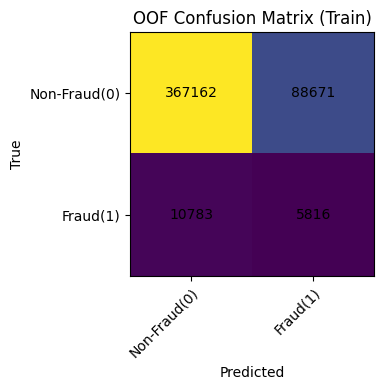

Scoring test set with model from fold 1 ...
Scoring test set with model from fold 2 ...
Scoring test set with model from fold 3 ...
Scoring test set with model from fold 4 ...
Scoring test set with model from fold 5 ...

=== Test metrics (threshold = OOF F1-opt) ===
roc_auc: 0.6304
pr_auc: 0.0475
accuracy: 0.5493
precision: 0.0514
recall: 0.6932
f1: 0.0957


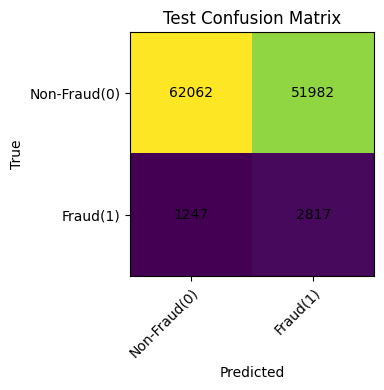

In [ ]:
#@title Threshold selection on OOF and evaluation
# Candidate 1: maximize F1 on OOF
best_th, best_f1 = best_threshold_by_f1(y_train, oof_scores)
print(f"OOF-chosen threshold (F1-opt): {best_th:.6f} | OOF F1: {best_f1:.4f}")

# Candidate 2: conservative threshold = 99.5% quantile of OOF non-fraud scores
nf_oof = oof_scores[y_train == 0]
quantile_th = float(np.quantile(nf_oof, 0.995))
print(f"Conservative threshold (0.995 quantile of normal OOF): {quantile_th:.6f}")

# We'll use F1-opt threshold for reporting, but keep both.
THRESHOLD = best_th

# OOF evaluation

oof_metrics, oof_pred = evaluate_scores(y_train, oof_scores, THRESHOLD)
print("\n=== OOF metrics (threshold = F1-opt) ===")
for k, v in oof_metrics.items():
    if k != 'cm':
        print(f"{k}: {v:.4f}")
plot_confusion_matrix(oof_metrics['cm'], title="OOF Confusion Matrix (Train)")

# Score the test set by averaging reconstruction error from all 5 fold-models
test_scores_each = []
for i, m in enumerate(models, start=1):
    print(f"Scoring test set with model from fold {i} ...")
    s = reconstruction_error(m, X_test_mat, batch_size=batch_size)
    test_scores_each.append(s)
test_scores = np.mean(np.vstack(test_scores_each), axis=0)

test_metrics, test_pred = evaluate_scores(y_test, test_scores, THRESHOLD)
print("\n=== Test metrics (threshold = OOF F1-opt) ===")
for k, v in test_metrics.items():
    if k != 'cm':
        print(f"{k}: {v:.4f}")
plot_confusion_matrix(test_metrics['cm'], title="Test Confusion Matrix")


  0%|          | 0/500 [00:00<?, ?it/s]

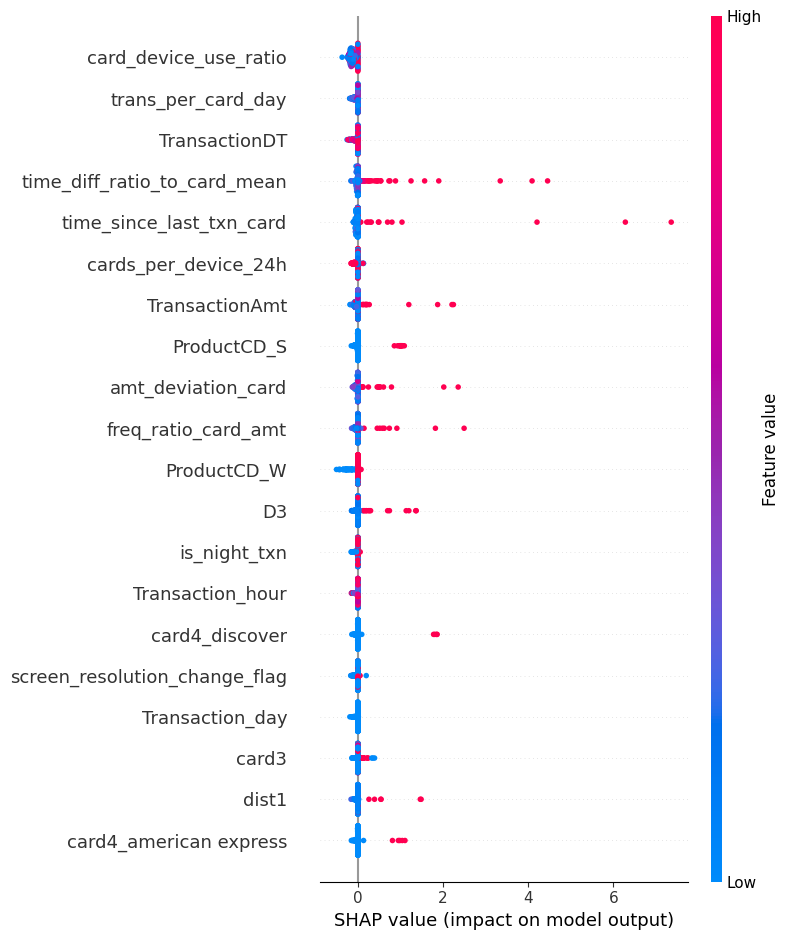

In [ ]:
# SHAP explanation of anomaly score (reconstruction error)

# 1) Train final AE on all non-fraud training data
X_train_nonfraud = X_train_mat[y_train == 0]

final_model = build_autoencoder(INPUT_DIM, hidden_layers, activation, dropout, l2, lr)
es = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
)
_ = final_model.fit(
    X_train_nonfraud, X_train_nonfraud,
    validation_split=0.05,      # still only within non-fraud
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False,
    verbose=0,
    callbacks=[es]
)

# 2) Function mapping X → scalar anomaly score (1-D array)
def anomaly_score_fn(X):
    X = np.array(X, dtype=np.float32)
    # return shape (n_samples,) so KernelExplainer treats it as single-output
    return reconstruction_error(final_model, X).astype(np.float32).ravel()

# 3) Background sample (for Kernel SHAP)
bg_size = min(1000, len(X_train_nonfraud))
background = X_train_nonfraud[:bg_size]

# 4) Subset of test points to explain
explain_n = min(500, X_test_mat.shape[0])
to_explain = X_test_mat[:explain_n]

# 5) Build explainer and compute SHAP values
explainer = shap.KernelExplainer(anomaly_score_fn, background)
shap_values = explainer.shap_values(to_explain, nsamples=100)

# If shap_values is a list (e.g., [array(n_samples, n_features)]), take first element
if isinstance(shap_values, list):
    shap_values_plot = shap_values[0]
else:
    shap_values_plot = shap_values

# 6) Plot SHAP summary with a better figure size
shap.initjs()
plt.figure(figsize=(8, 6))     # wider, less “skyscraper”
shap.summary_plot(
    shap_values_plot,
    to_explain,
    feature_names=feature_cols,
    show=True
)


In [ ]:
#@title Save OOF and Test predictions to CSV (keeps chronology)
oof_df = pd.DataFrame({
    "row_idx": np.arange(len(oof_scores)),
    "score": oof_scores,
    "pred_label": (oof_scores >= THRESHOLD).astype(int),
    "true_label": y_train,
    "fold": oof_fold
})
if TX_TIME_COL:
    oof_df[TX_TIME_COL] = X_train[TX_TIME_COL].values

test_df = pd.DataFrame({
    "row_idx": np.arange(len(test_scores)),
    "score": test_scores,
    "pred_label": (test_scores >= THRESHOLD).astype(int),
    "true_label": y_test
})
if TX_TIME_COL and TX_TIME_COL in X_test.columns:
    test_df[TX_TIME_COL] = X_test[TX_TIME_COL].values

oof_csv  = os.path.join(datapath, "oof_predictions.csv")
test_csv = os.path.join(datapath, "test_predictions.csv")
oof_df.to_csv(oof_csv, index=False)
test_df.to_csv(test_csv, index=False)

print("Saved:")
print(" -", oof_csv)
print(" -", test_csv)


Saved:
 - /content/drive/MyDrive/RThesis/oof_predictions.csv
 - /content/drive/MyDrive/RThesis/test_predictions.csv


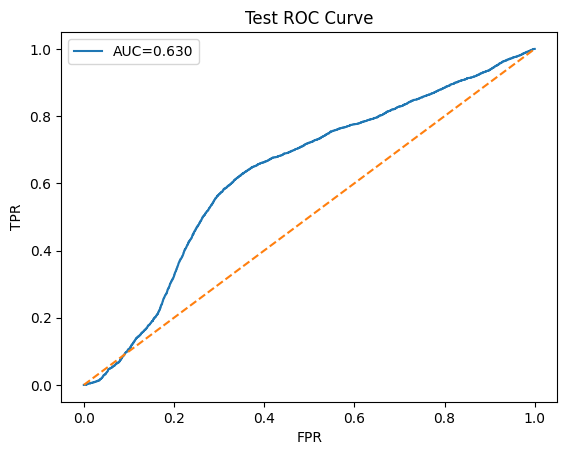

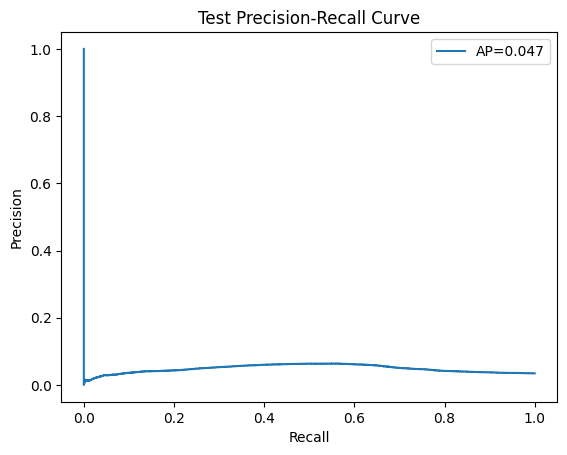

In [ ]:
#@title ROC & PR curves for test (diagnostic)
from sklearn.metrics import auc

def plot_roc_pr(y_true, scores, title_prefix=""):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} ROC Curve")
    plt.legend(); plt.show()
    # PR
    prec, rec, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(rec, prec)
    plt.figure()
    plt.plot(rec, prec, label=f"AP={pr_auc:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend(); plt.show()

plot_roc_pr(y_test, test_scores, title_prefix="Test")


In [ ]:
print(X_train.shape)
print(X_train.columns)


(472432, 47)
Index(['TransactionAmt', 'dist1', 'dist2', 'Transaction_day',
       'Transaction_hour', 'is_night_txn', 'trans_per_card_day',
       'avg_amt_per_card_y', 'amt_deviation_card', 'freq_ratio_card_amt',
       'dist_ratio', 'TransactionDT', 'card3', 'card5', 'D1', 'D2', 'D3', 'D4',
       'trans_last_1h_card', 'trans_last_6h_card', 'trans_last_24h_card',
       'time_since_last_txn_card', 'devices_per_card_24h',
       'cards_per_device_24h', 'device_change_flag', 'browser_change_flag',
       'os_change_flag', 'screen_resolution_change_flag', 'geo_change_flag',
       'card_device_use_ratio', 'time_diff_ratio_to_card_mean', 'index',
       'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_american express', 'card4_discover',
       'card4_mastercard', 'card4_unknown', 'card4_visa', 'card6_charge card',
       'card6_credit', 'card6_debit', 'card6_debit or credit',
       'card6_unknown'],
      dtype='object')
